In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
matplotlib.rcParams.update({'font.size': 14})

## Read prepared B data for track-based and vertex-based tagging

In [3]:
import pandas
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_MC.csv')
Bdata_vertex = pandas.read_csv('models/Bdata_vertex_MC_v.csv')

In [4]:
Bdata_tracks.head()

,Bsign,Bweight,event_id,track_relation_prob
0,-1,1,2498001_1,0.652731
1,1,1,2498001_10,1.892640
2,1,1,2498001_105,1.077080
3,1,1,2498001_108,0.985524
4,1,1,2498001_11,1.086548


In [5]:
Bdata_vertex.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,-1,1,2498001_160,1.296642
1,-1,1,2498001_173,1.671069
2,-1,1,2498001_39,0.550335
3,1,1,2498001_43,0.827923
4,1,1,2498001_89,0.540587


### Merge two datasets

In [6]:
Bdata = Bdata_vertex #pandas.merge(Bdata_tracks, Bdata_vertex, how='outer', on=['event_id', 'Bsign'])

In [7]:
Bdata.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,-1,1,2498001_160,1.296642
1,-1,1,2498001_173,1.671069
2,-1,1,2498001_39,0.550335
3,1,1,2498001_43,0.827923
4,1,1,2498001_89,0.540587


### Obtain one weight column

In [8]:
# Bdata['Bweight'] = Bdata['Bweight_x'].copy()
# Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight'] = Bdata.ix[numpy.isnan(Bdata['Bweight'].values), 'Bweight_y']
# Bdata = Bdata.drop(['Bweight_x', 'Bweight_y'], axis=1)

# for Nan put 1 as non influence factor
# Bdata.ix[numpy.isnan(Bdata.track_relation_prob.values), 'track_relation_prob'] = 1.
Bdata.ix[numpy.isnan(Bdata.vertex_relation_prob.values), 'vertex_relation_prob'] = 1.

In [9]:
Bdata.head()

,Bsign,Bweight,event_id,vertex_relation_prob
0,-1,1,2498001_160,1.296642
1,-1,1,2498001_173,1.671069
2,-1,1,2498001_39,0.550335
3,1,1,2498001_43,0.827923
4,1,1,2498001_89,0.540587


In [10]:
relation_prob = Bdata['vertex_relation_prob'].values #* Bdata['vertex_relation_prob'].values
Bprob = relation_prob / (1 + relation_prob)
Bweight = Bdata.Bweight.values
Bsign = Bdata.Bsign.values

In [11]:
# sum(Bdata['vertex_relation_prob'].values == 0)

In [12]:
Bprob[~numpy.isfinite(Bprob)] = 0.5

## 2-folding calibration by isotonic

In [13]:
from utils import calibrate_probs
Bprob_calibrated, (iso_reg1, iso_reg2) = calibrate_probs(Bsign, Bweight, Bprob,
                                                         symmetrize=True, return_calibrator=True)

#### Add some small noise in prediction for stability

In [14]:
Bprob_calibrated = Bprob_calibrated + numpy.random.normal(size=len(Bprob_calibrated)) * 0.001

((array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
  <a list of 6 Text xticklabel objects>),
 (array([    0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,
          8000.,  9000.]), <a list of 10 Text yticklabel objects>))

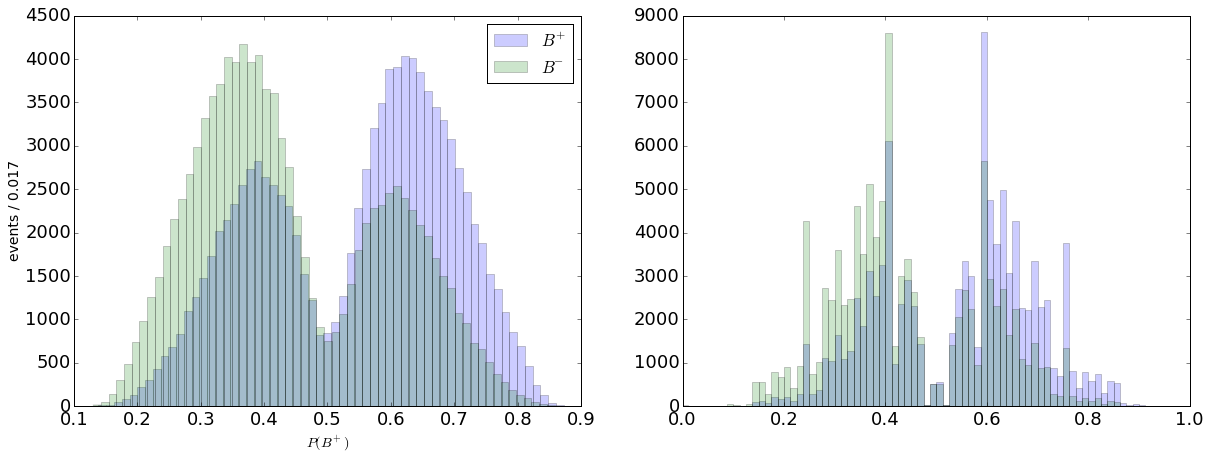

In [15]:
figure(figsize=(20, 7))

subplot(1,2,1)
hist(Bprob[Bsign == 1], weights=Bweight[Bsign == 1], bins=60, alpha=0.2,  label='$B^+$')
hist(Bprob[Bsign == -1], weights=Bweight[Bsign == -1], bins=60, alpha=0.2,  label='$B^-$')
legend(), xlabel('$P(B^+)$'), ylabel('events / 0.017')
xticks(fontsize=18), yticks(fontsize=18)
subplot(1,2,2)
hist(Bprob_calibrated[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
      range=(0, 1), label='$B^+$')
hist(Bprob_calibrated[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
      range=(0, 1), label='$B^-$')
ylim(0, )
xticks(fontsize=18), yticks(fontsize=18)
# legend(), xlabel('calibrated $P(B^+)$'), ylabel('events / 0.017')
# plt.savefig('img/Bprob_iso_calibrated_PID_less.png' , format='png')
# plt.savefig('img/paper_B_prob.png', dpi=300, format='png', bbox_inches='tight')

## AUC score and ROC curve for B+ vs B-

AUC for tagged: 0.612968658183 AUC with untag: 0.55131762761


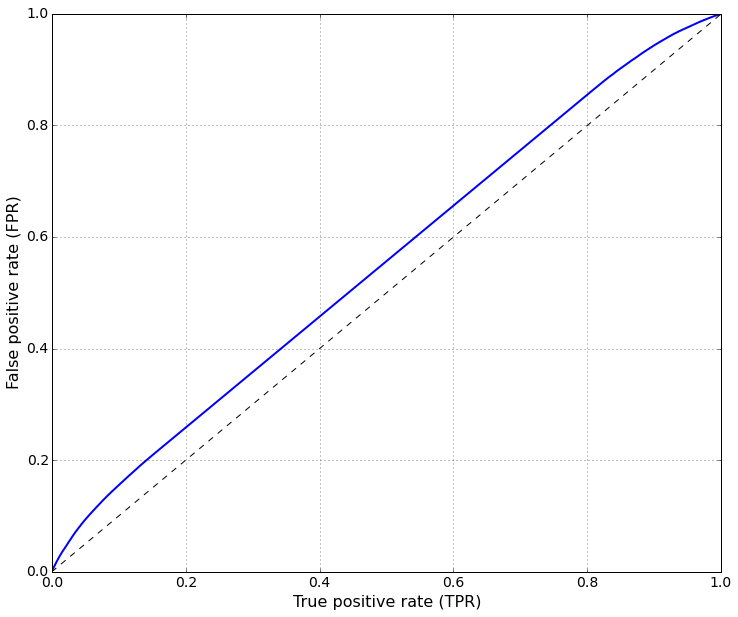

In [52]:
from utils import calculate_auc_with_and_without_untag_events, calculate_roc_with_untag_events
from sklearn.metrics import roc_curve

auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprob_calibrated, Bweight, N_B)
print 'AUC for tagged:', auc, 'AUC with untag:', auc_full

figure(figsize=(12, 10))
fpr, tpr, _ = calculate_roc_with_untag_events(Bsign, Bprob_calibrated, Bweight, N_B)
plot(fpr, tpr, linewidth=2)
plot([0, 1], [0, 1], 'k--')
ylim(0, 1), xlim(0, 1)
xlabel('True positive rate (TPR)', fontsize=16)
ylabel('False positive rate (FPR)', fontsize=16)
grid()
# plt.savefig('img/poster_B_roc.png' , dpi=700, format='png', transparent=True)

## Symmetry $B^+$ vs $B^-$ checking

### before calibration

(<matplotlib.legend.Legend at 0x7fc49b48a490>,
 <matplotlib.text.Text at 0x7fc496102050>)

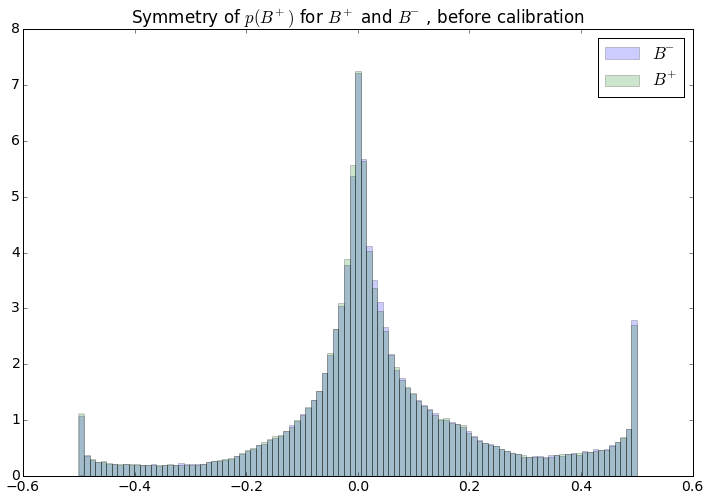

In [20]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob[Bsign == sign] - 0.5), bins=101, normed=True, alpha=0.2, 
         weights=Bweight[Bsign == sign], range=(-0.5, 0.5), label='$B^-$' if sign == -1 else '$B^+$')
legend(), title('Symmetry of $p(B^+)$ for $B^+$ and $B^-$, before calibration')

#### KS distance

In [21]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

In [22]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.0076533582573269365)

((0, 1), (0, 1))

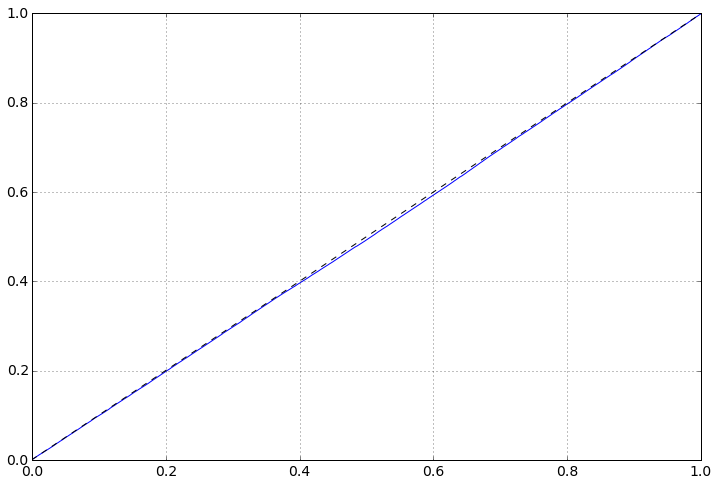

In [23]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)


In [24]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Bsign, (Bprob - 0.5) * Bsign, sample_weight=Bweight)

0.49666032000144283

### after calibration

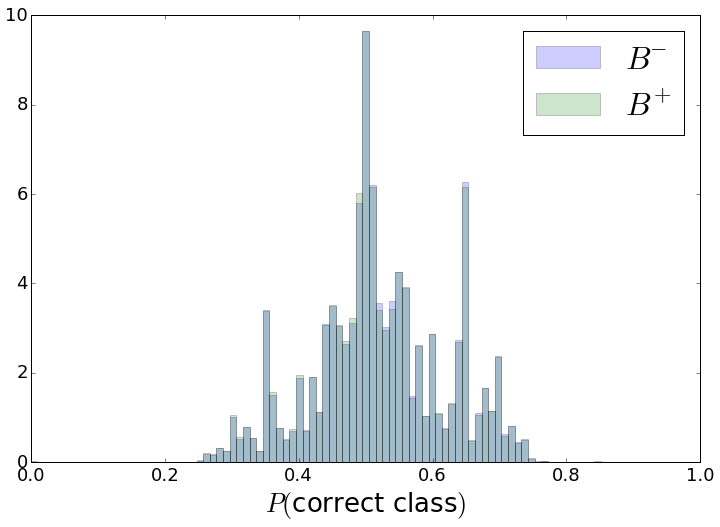

In [25]:
figsize(12, 8)
for sign in [-1, 1]:
    hist(sign * (Bprob_calibrated[Bsign == sign] - 0.5) + 0.5, bins=101,  alpha=0.2,
         weights=Bweight[Bsign == sign], range=(0, 1), normed=True, label='$B^-$' if sign == -1 else '$B^+$')
legend(fontsize=32); ylim(0, ), xlim(0, 1)
xticks(fontsize=18), yticks(fontsize=18)
xlabel('$P($correct class$)$', fontsize=26)
# plt.savefig('img/paper_symmetry.png' , dpi=300, format='png',  bbox_inches='tight')

#### KS distance

In [26]:
fpr, tpr, _ = roc_curve(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

In [27]:
'KS distance', max(abs(fpr - tpr))

('KS distance', 0.0078280796936212038)

((0, 1), (0, 1))

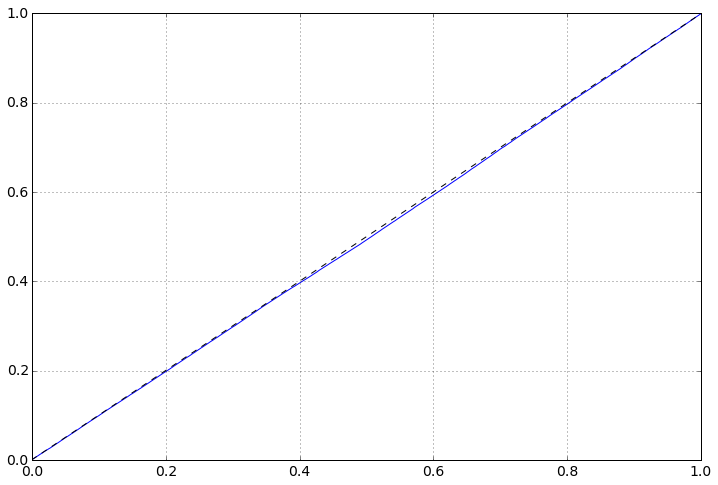

In [28]:
plot(fpr, tpr), grid()
plot([0, 1], [0, 1], 'k--')
xlim(0, 1), ylim(0, 1)

In [29]:
roc_auc_score(Bsign, (Bprob_calibrated - 0.5) * Bsign, sample_weight=Bweight)

0.49666944297893789

## D2 estimation with bootstrap calibration

In [30]:
from utils import compute_N_B_events_MC

In [31]:
from utils import result_table

In [32]:
N_B = compute_N_B_events_MC('datasets/MC/csv/Bu_JPsiK/Tracks.root', 'datasets/MC/csv/Bu_JPsiK/Vertices.root')

AUC 0.612957395686 4.5020141528e-07


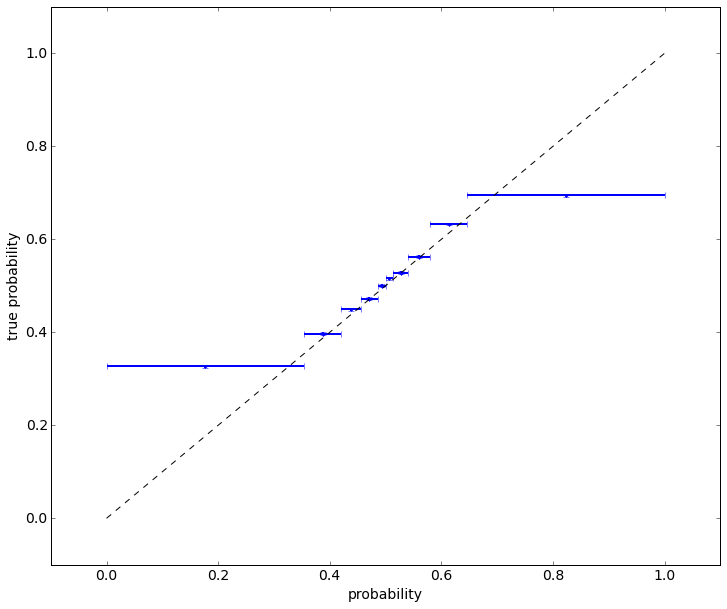

In [47]:
from utils import get_N_B_events, bootstrap_calibrate_prob, result_table

N_B_passed = Bweight.sum()
tagging_efficiency = N_B_passed / N_B
tagging_efficiency_delta = numpy.sqrt(N_B_passed) / N_B

D2, aucs = bootstrap_calibrate_prob(Bsign, Bweight, Bprob, symmetrize=True, n_calibrations=30)
print 'AUC', numpy.mean(aucs), numpy.var(aucs)

result = result_table(tagging_efficiency, tagging_efficiency_delta, D2, auc_full, 'Inclusive tagging, PID less')

In [51]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Inclusive tagging, PID less",36.989612,0.049843,0.040663,0.000454,1.504121,0.016917,55.131763,0


In [3]:
result

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Inclusive tagging, PID less",99.999556,0.074515,0.08447,0,8.446962,0.006294,66.368665,0


## Some plots

### Isotonic transformation, and its reverse (too check symmetry)

(<matplotlib.text.Text at 0x7fc495693b90>,
 <matplotlib.text.Text at 0x7fc49562d050>)

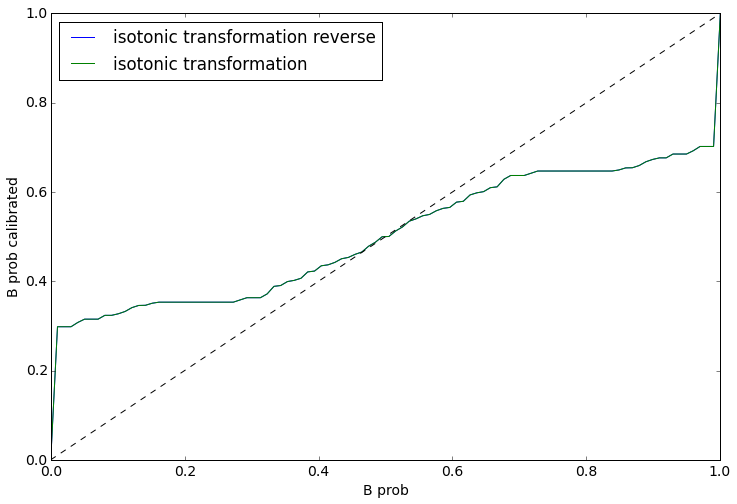

In [33]:
x = numpy.linspace(0, 1, 100)
plot(x, -(iso_reg1.transform((1-x)) + iso_reg2.transform((1-x))) / 2 + 1, label='isotonic transformation reverse')
plot(x, (iso_reg1.transform(x) + iso_reg2.transform(x)) / 2, label='isotonic transformation')
legend(loc='best')
plot([0, 1], [0, 1], "k--")
xlabel('B prob'), ylabel('B prob calibrated')
# plt.savefig('img/iso_transformation_PID_less.png' , format='png')

### Mistag checking

In [16]:
from utils import get_N_B_events, compute_mistag

In [17]:
bins = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
percentile_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

### before calibration

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


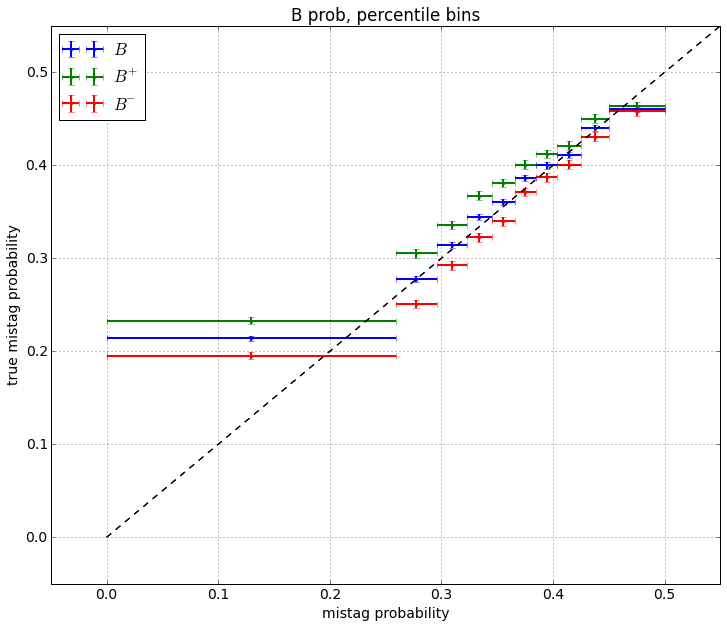

In [18]:
figsize(12, 10)
compute_mistag(Bprob, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob, percentile bins')

### after calibration

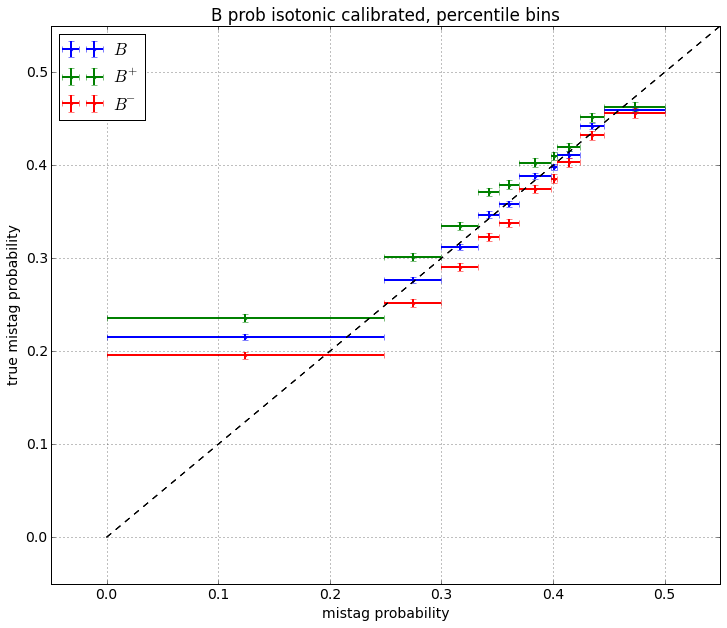

In [19]:
figsize(12, 10)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign > -100, label="$B$", uniform=False,
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == 1, label="$B^+$", uniform=False, 
               bins=percentile_bins)
compute_mistag(Bprob_calibrated, Bsign, Bweight, Bsign == -1, label="$B^-$", uniform=False, 
               bins=percentile_bins)
legend(loc='best'),  xlabel('mistag probability'), ylabel('true mistag probability')
title('B prob isotonic calibrated, percentile bins')

In [46]:
print numpy.average((2*(Bprob - 0.5))**2, weights=Bweight) * tagging_efficiency * 100
print numpy.average((2*(Bprob_calibrated - 0.5))**2, weights=Bweight) * tagging_efficiency * 100

6.03235897745
1.50282488033
